In this notebook, we:
* select a subset based on indicators derived from the text and related data
    * we do not process the text as thorougly at this step because we are only working with entire threads at this point, so it should be expected that the vocabulary we are searching for appear at least once in each thread.
* process text so that it can be better evaluated in further steps.

In [1]:
#if jupyternotify is installed, we can add %notify to a cell to get an alert when it ifnished running
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
import metrics_helpers as indicators
import pickle as pk
import gc
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Create Indicators

In [3]:
def dt_to_int(dt): #datetime to integer
    return dt.astype('int')/(10**9)

In [4]:
#netmums


with open('/Users/sma/Documents/INRAE internship/scrape-git/netmums/allposts_rerun.pkl', 'rb') as f:
    netmums = pk.load(f)

    
nm_ind = indicators.indicators(netmums, fb=False)
#this one takes long, around 20 seconds I think.

nm_ind.add_term_counts()
nm_ind.add_url_term_counts()
nm_ind.add_total_likes()
nm_ind.add_available_comments()
nm_ind.add_comment_activity()
nm_ind.add_num_unique_posters()
nm_ind.add_num_urls()
nm_ind.add_avg_post_length()
nm_ind.add_post_time()
nm_ind.add_lexical_richness()
nm_ind.add_term_distance_simple()

netmums = nm_ind.results_dict

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
distance_data = [item.get('term_distance_simple') for item in netmums.values()]
pd.Series([item is not None for item in distance_data]).value_counts()

False    3904
True     2619
dtype: int64

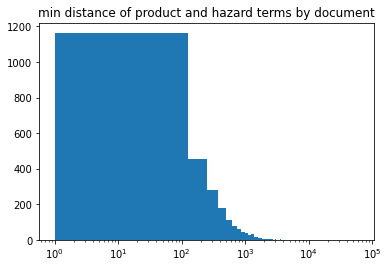

In [6]:
#now plot distributino of values.
plt.hist([item for item in distance_data if item is not None], bins=500)
plt.title('min distance of product and hazard terms by document')
plt.xscale('log')

In [7]:
pd.Series(distance_data).sort_values().value_counts(sort=False)

1.0       115
2.0        10
3.0        26
4.0        14
5.0        16
         ... 
583.0       2
1523.0      1
669.0       1
827.0       1
4232.0      1
Length: 884, dtype: int64

Text(0.5, 1.0, 'min distance of product and hazard terms by document')

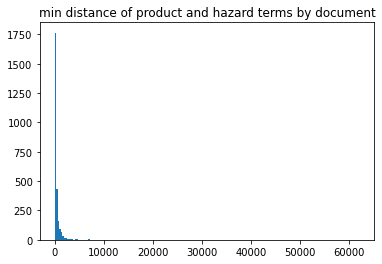

In [8]:
#now plot distributino of values.
plt.hist([item for item in distance_data if item is not None], bins=200)
plt.title('min distance of product and hazard terms by document')
#plt.xscale('log')

In [9]:
import pandas as pd

In [10]:
nmdf = pd.DataFrame.from_dict(netmums).transpose()
nmdf = nmdf.drop(columns=['posts', 'term_counts', 'url_term_counts', 'query'])

# Pre-processing


## move term counts to separate columns

### netmums

In [11]:
terms = list([n for n in netmums.values()][0]['term_counts'].keys())

for term_key in terms:
    d = {url_key: value['term_counts'][term_key] for url_key, value in netmums.items()}
    nmdf['term_counts_' + term_key] = nmdf.index.map(d)
    
for term_key in terms:
    d = {url_key: value['url_term_counts'][term_key] for url_key, value in netmums.items()}
    nmdf['url_term_counts_'+ term_key] = nmdf.index.map(d)

In [12]:
nmdf = nmdf.reset_index()
nmdf = nmdf.rename(columns={"index":"url"})
nmdf

,url,title,total_likes,available_comments,comment_activity,num_unique_posters,num_urls,avg_post_length,post_time,lexical_richness,...,url_term_counts_toxic,url_term_counts_toxin,url_term_counts_veg,url_term_counts_vegetable,url_term_counts_veggie,url_term_counts_vet,url_term_counts_veterinary,url_term_counts_virus,url_term_counts_vomitoxin,url_term_counts_yoghurt
0,https://www.netmums.com/coffeehouse/drop-clini...,Aptamil Hungry Baby making LO sick??,0,20,20,2,4,929.1,2011-10-30 08:56:00,141.759,...,0,0,0,0,0,0,0,0,0,0
1,https://www.netmums.com/coffeehouse/becoming-m...,Mam bottles,0,17,17,5,0,200.353,2016-01-20 12:41:00,120.208,...,0,0,0,0,0,0,0,0,0,0
2,https://www.netmums.com/coffeehouse/other-chat...,DEAD INSECT IN SAINSBURYS FOOD!,0,30,30,9,0,213.8,2012-02-19 19:55:00,190.436,...,0,0,0,0,0,0,0,0,0,0
3,https://www.netmums.com/coffeehouse/home-garde...,buying a house near a factory is it a bad idea?,0,5,5,3,1,534,2017-09-04 21:13:00,133.82,...,0,0,0,0,0,0,0,0,0,0
4,https://www.netmums.com/coffeehouse/home-garde...,URGENT ADVISE NEEDED PLEASE - oven cleaner fumes,0,5,5,1,0,228.8,2007-11-18 22:51:00,99.834,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6518,https://www.netmums.com/coffeehouse/becoming-m...,Thrush treatment in late pregnancy,0,14,14,2,0,337.071,2011-05-02 19:12:00,112.864,...,0,0,0,0,0,0,0,0,0,0
6519,https://www.netmums.com/coffeehouse/becoming-m...,Does anyone know .............,0,12,12,2,0,260.583,2014-07-29 22:25:00,155.432,...,0,0,0,0,0,0,0,0,0,0
6520,https://www.netmums.com/coffeehouse/being-mum-...,kids shopping trolleys,0,7,7,1,0,327,2012-04-13 18:47:00,141.132,...,0,0,0,0,0,0,0,0,0,0
6521,https://www.netmums.com/coffeehouse/other-chat...,Halloween food ideas,0,12,12,9,6,483.083,2016-10-31 20:20:00,138.818,...,0,0,0,0,0,0,0,0,0,0


In [13]:
gc.collect()

20

## Create two term totals
combine counts for terms which are hazards and terms which are products.

In [14]:
#choose terms to count in totals
term_count_df = nmdf[nmdf.columns[pd.Series(nmdf.columns).str.startswith('term_counts_')]]

products = term_count_df.columns[[5,12,13,17,33, 34, 35, 44,45,57, 58, 65,66,68, 69,70,78, 79,80, 85]]
hazards = term_count_df.columns[[1,2,3,9,10,11,14,15,16,18,
                                 19,20,21,22,23,24,25,26,27,
                                 28,30,31,37,38,39,40,
                                 41,42,43,46,47,48,49,50,51,
                                 52,53,54,55,56,59,60,61,62,
                                 63,64,67,71,72,73,74,75,76,
                                 77,81,82,83,84]]


In [15]:
hazards

Index(['term_counts_acrylamid', 'term_counts_acrylamide',
       'term_counts_additives', 'term_counts_bacteria',
       'term_counts_biphenyls', 'term_counts_bisphenol', 'term_counts_bpa',
       'term_counts_campylobacter', 'term_counts_carcinogen',
       'term_counts_chemical', 'term_counts_chemicals',
       'term_counts_contaminants', 'term_counts_contaminated',
       'term_counts_cronobacter', 'term_counts_deoxynivalenol',
       'term_counts_dioxin', 'term_counts_disruptor', 'term_counts_drugs',
       'term_counts_e-coli', 'term_counts_ecoli', 'term_counts_endocrine',
       'term_counts_estrogen', 'term_counts_fungus', 'term_counts_genetically',
       'term_counts_gm', 'term_counts_gmo', 'term_counts_hazard',
       'term_counts_histamine', 'term_counts_hydrocarbons',
       'term_counts_listeria', 'term_counts_metals', 'term_counts_microbes',
       'term_counts_microbiologic', 'term_counts_moah', 'term_counts_modified',
       'term_counts_moh', 'term_counts_mold', 'term_

In [16]:
products

Index(['term_counts_applesauce', 'term_counts_bottle',
       'term_counts_bottle-fed', 'term_counts_cereal', 'term_counts_food',
       'term_counts_for', 'term_counts_formula', 'term_counts_jar',
       'term_counts_jarred', 'term_counts_oatmeal', 'term_counts_oats',
       'term_counts_porridge', 'term_counts_premade', 'term_counts_pudding',
       'term_counts_puree', 'term_counts_purée', 'term_counts_veg',
       'term_counts_vegetable', 'term_counts_veggie', 'term_counts_yoghurt'],
      dtype='object')

create the totals of terms in two categories.

In [17]:
#netmums
#add totals
term_count_df = nmdf[nmdf.columns[pd.Series(nmdf.columns).str.startswith('term_counts_')]]

products = term_count_df.columns[[5,12,13,17,33, 34, 35, 44,45,57, 58, 65,66,68, 69,70,78, 79,80, 85]]
hazards = term_count_df.columns[[1,2,3,4,6,7,8,9,10,11,14,15,16,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,36,37,38,39,40,41,42,43,46,47,48,49,50,51,52,53,54,55,56,59,60,61,62,63,64,67,71,72,73,74,75,76,77,81,82,83,84]]


term_count_hazard_df = term_count_df[hazards]
term_count_product_df = term_count_df[products]

url_term_count_df = nmdf[nmdf.columns[pd.Series(nmdf.columns).str.startswith('url_term_counts_')]]

url_term_count_hazard_df = url_term_count_df['url_' + hazards]
url_term_count_product_df = url_term_count_df['url_' + products] 


nmdf['total_term_count'] = term_count_df.sum(axis=1) #make sure there's no s because we can easily filter the non totals then with contains.
nmdf['total_url_term_count'] = term_count_df.sum(axis=1)

nmdf['total_term_count_hazard'] = term_count_hazard_df.sum(axis=1) #make sure there's no s because we can easily filter the non totals then with contains.
nmdf['total_url_term_count_hazard'] = url_term_count_hazard_df.sum(axis=1)

nmdf['total_term_count_product'] = term_count_product_df.sum(axis=1) #make sure there's no s because we can easily filter the non totals then with contains.
nmdf['total_url_term_count_product'] = url_term_count_product_df.sum(axis=1)

## Examine the Pandas Dataframes.

In [18]:
#we want to plot these
nmdf[nmdf.columns[pd.Series(nmdf.columns).str.contains('term_counts_') == 0]].drop(['url','title'],axis=1)

,total_likes,available_comments,comment_activity,num_unique_posters,num_urls,avg_post_length,post_time,lexical_richness,term_distance_simple,total_term_count,total_url_term_count,total_term_count_hazard,total_url_term_count_hazard,total_term_count_product,total_url_term_count_product
0,0,20,20,2,4,929.1,2011-10-30 08:56:00,141.759,95,68,68,38,0,30,0
1,0,17,17,5,0,200.353,2016-01-20 12:41:00,120.208,143,4,4,2,0,2,0
2,0,30,30,9,0,213.8,2012-02-19 19:55:00,190.436,25,28,28,15,0,13,0
3,0,5,5,3,1,534,2017-09-04 21:13:00,133.82,None,4,4,4,0,0,0
4,0,5,5,1,0,228.8,2007-11-18 22:51:00,99.834,None,2,2,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6518,0,14,14,2,0,337.071,2011-05-02 19:12:00,112.864,366,4,4,2,0,2,0
6519,0,12,12,2,0,260.583,2014-07-29 22:25:00,155.432,None,4,4,3,0,1,0
6520,0,7,7,1,0,327,2012-04-13 18:47:00,141.132,113,2,2,1,0,1,0
6521,0,12,12,9,6,483.083,2016-10-31 20:20:00,138.818,39,8,8,1,0,7,0


In [19]:
gc.collect()

52

## Post-2016 Subset

In [20]:
from datetime import datetime

In [21]:
time_cutoff = datetime(2016,1,1, 0, 0, 0, 0)

In [22]:
nmdf = nmdf.loc[nmdf.post_time >= time_cutoff]

# Make Indicators Relative so More Easily Interpreted.

In [23]:
#TODO adjust this for the new indicators...
#will involve some playing around / investigating I guess.

nmdf = nmdf.copy()
#so we don't get an error for operating on a slice or sth

In [24]:
nmdf['total_term_count'] = nmdf['total_term_count'] / (nmdf['avg_post_length'] + 1)
nmdf['total_term_count_hazard'] = nmdf['total_term_count_hazard'] / (nmdf['avg_post_length'] + 1)
nmdf['total_term_count_product'] = nmdf['total_term_count_product'] / (nmdf['avg_post_length'] + 1)
#FIXME divide by available comments insteand of average post length (for netmums only.)

nmdf['num_unique_posters'] = nmdf['num_unique_posters'] / (nmdf['available_comments'] + 1)

## Modify Time so We can Graph It.

In [25]:
from datetime import datetime
nmdf['int_post_time'] = dt_to_int(nmdf.post_time.dropna()) 

# Pair Plots

Take a sample of 500 points and plot the pair plots of our indicators.
Datetime could not be plotted, so it's converted to int. We can estimate on the graph what the corresponding date is by looking at quantiles.
Lexical richness uses a measure called MTLD, which should be less biased for short documents than the most common TTR (Type-Token Ratio)


In [26]:
nm_indicators = \
['total_term_count',
'total_term_count_hazard',
'total_term_count_product',
'num_unique_posters',
'avg_post_length',
'lexical_richness', 
'term_distance_simple']



## Netmums

In [27]:
nmdf[nmdf.columns[nmdf.columns.isin(nm_indicators)]].loc[nmdf.term_distance_simple.isnull()]

,num_unique_posters,avg_post_length,lexical_richness,term_distance_simple,total_term_count,total_term_count_hazard,total_term_count_product
3,0.5,534,133.82,None,0.00747664,0.00747664,0
5,0.285714,396.231,143.273,None,0.0201394,0.017622,0.00251743
10,0.48,329.082,123.96,None,0.00908866,0.00605911,0.00302955
12,0.7,383.889,155.024,None,0.00259815,0.00259815,0
19,0.333333,921.643,149.068,None,0.00216769,0.00216769,0
...,...,...,...,...,...,...,...
6480,0.44,241.708,138.199,None,0.148326,0.0618026,0.0865236
6487,0.375,413.867,135.984,None,0.0361562,0.00964165,0.0265145
6509,0.277778,466.647,193.298,None,0.0983648,0.0491824,0.0491824
6513,0.277778,777.471,140.825,None,0.00128457,0,0.00128457


In [28]:
nmdf[nmdf.columns[nmdf.columns.isin(nm_indicators)]].loc[nmdf.term_distance_simple.notnull()]

,num_unique_posters,avg_post_length,lexical_richness,term_distance_simple,total_term_count,total_term_count_hazard,total_term_count_product
1,0.277778,200.353,120.208,143,0.0198656,0.00993281,0.00993281
7,0.1875,493.667,107.033,104,0.0202156,0.00808625,0.0121294
27,0.222222,523.75,170.738,48,0.034302,0.017151,0.017151
38,0.8,928.75,197.805,153,0.00322667,0.00215112,0.00107556
40,0.735294,223.939,182.328,87,0.0666846,0.00889128,0.0577933
...,...,...,...,...,...,...,...
6428,0.14433,343.42,164.697,211,0.65908,0.409384,0.249695
6444,0.211009,421.657,145.405,327,0.30048,0.191645,0.108835
6498,0.636364,467.333,188.526,7,0.0448399,0.0256228,0.0192171
6502,0.875,426.143,146.963,74,0.0327759,0.0187291,0.0140468


### Graph of Only Term Counts

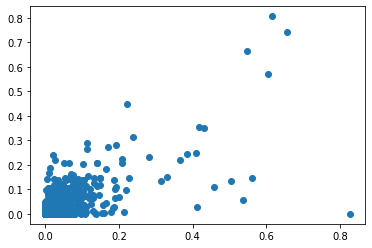

In [29]:
view = nmdf.loc[nmdf.total_term_count_hazard <1].loc[nmdf.total_term_count_product <1]
plt.scatter(view.total_term_count_hazard, view.total_term_count_product)

In [30]:
a = nmdf.dropna()['term_distance_simple']
b = nmdf.dropna()['lexical_richness']

In [31]:
tempdf = pd.DataFrame([list(a),list(b)]).transpose()
tempdf = tempdf.rename(columns={0:'term', 1:'lex'})

In [32]:
blah = nmdf.term_distance_simple / ( nmdf.avg_post_length * nmdf.available_comments)

In [33]:
a = blah.dropna()

tempdf = pd.DataFrame([list(a),list(b)]).transpose()
tempdf = tempdf.rename(columns={0:'term', 1:'lex'})

# Final Set of Criterion

 * year >= 2016
 * non-zero occurences of both a product and a hazard term
 * distance between product and hazard is below the 95th percentile.
 
 * if this approach proves not to yield results, we can instead attempt to take a subset based on the subforum which results occur in !

# Basic Descriptive Statistics


## Netmums

In [34]:
#get the sub foruma nd sub sub forum that results are in 
site_area = view.url.str.extract('netmums.com\/coffeehouse\/(?P<subforum>[^\/]+)\/(?P<subsubforum>[^\/]+)')

<AxesSubplot:>

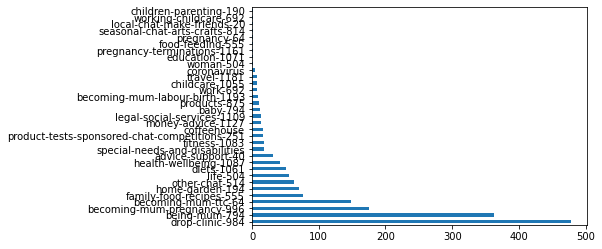

In [35]:
site_area['subforum'].value_counts().plot.barh()

<AxesSubplot:>

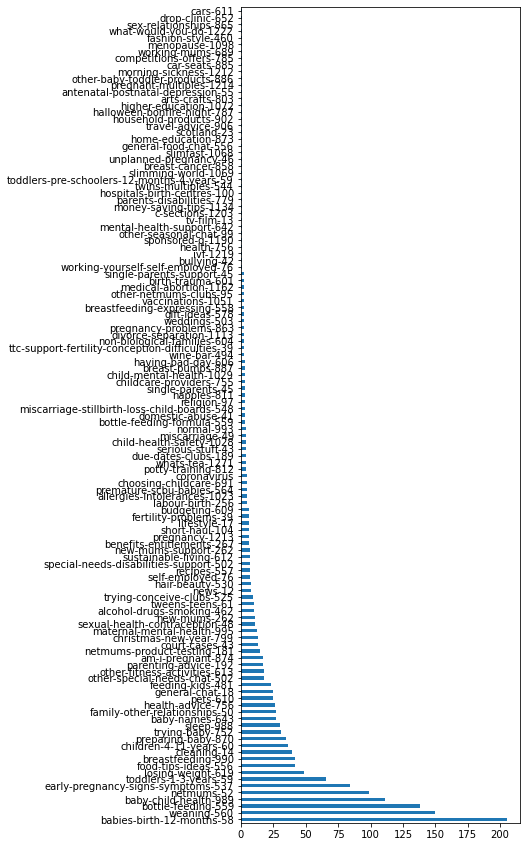

In [36]:
site_area['subsubforum'].value_counts().plot.barh(figsize=(5,15))

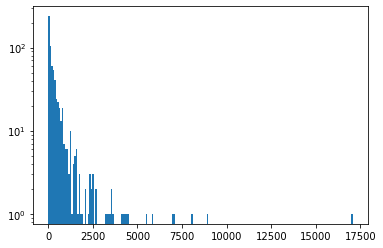

In [37]:
plt.hist([i for i in view.term_distance_simple if i], bins=200)
plt.yscale('log')

In [38]:
np.quantile([i for i in view.term_distance_simple if i], [0.25,0.5,0.75, 0.95])

array([  43.  ,  169.  ,  480.75, 1784.6 ])

### Export the Keys for our Desired Subset.

In [39]:
#export the keys #TODO
temp = nmdf.loc[nmdf.total_term_count_hazard > 0].loc[nmdf.total_term_count_product > 0].loc[nmdf.post_time >= time_cutoff].loc[nmdf.term_distance_simple <= 491]

In [40]:
with open('netmums_subset_keys.txt','w') as f:
	f.writelines([i + "\n" for i in list(temp.url)])

# Clean Text
We now construct our subset form the desired keys and then process the text.
* remove typos of relevant words using Levenshtein Distances
* replace tokens for specific foods and brands with their category, after compiling lists of these terms using word2vec
    * replace tokens for all types of fruits with fruit
    * replace tokens for all types of vegetable with vegetable
    * replace tokens for all types of grains with "cereal" (???) should I??

### Setup: Create Lists for Revelant Terms

In [41]:
baby_formula = \
['nutramigen',
 'neocate',
 'powdered milk',
 'infasoy',
 'comfort milk', #brand name which people dont write formula alongside
 'sma' 
]

baby_cereal = \
['baby rice '#this one is really useful / important. idk how exactly to handle it.
'rusks' #a cereal food for babies to teethe with
]

cereal = \
['cornflakes',
'muesli',
'bran flakes',
'cheerios',
'shreddies',
'weetabix',
'ready brek',
'rice pudding',
'rice'
]

fruit = \
['banana',
'berries',
'blueberries',
'raisins',
'apples',
'pear',
'strawberries',
'pineapple', 
'raspberries',
'mango', 
'prunes', 
'grapefruit']

veg = \
['mushroom', 
'red_pepper',
'green_beans', 
'courgette', 
'broccoli', 
'tomato',
'parsnips', 
'greens', 
'potato', 
'carrots',
'broccoli',
'cucumber', 
'peas', 
'tomatoes', 
'sweet_potato',
'sweetcorn', 
'corn', 
'spinach', 
'cauliflower',
'butternut squash', 
'beetroot',
'squash']

In [42]:
foodwords = [
#infant formula
"formula","baby formula", "bottle-fed", "bottle",
#sterizlized vegetable mixed with fish
"veggie baby food","vegetable baby food",
"veg puree", "veg purée",
#fresh fruit puree mildly processed
"fruit puree","fruit baby food", "fruit purée", "applesauce",
#infant cereals
"cereal for baby", "cereal", "porridge", "oats", "oatmeal",
#other
"jar food", "baby food", "jarred", "premade food", "puree", "purée", "jarred food"
,"yoghurt", "pudding"]

hazardwords = ["Chemical contaminants",#ENDOCRINE DISRUPTOR
"Endocrine disruptor","endocrine","estrogen",#end
#FOOD PRESERVATIVES, SWEETENERS AND ADDITIVES
"preservatives","sweeteners","additives", #end
"Pesticides",#VETERINARY DRUGS
"Veterinary drugs","animal drugs","vet drugs", #end
#GMO
"GMO", "genetically modified",#end
"Metals","Mycotoxin",#BISPHENOL A
"Bisphenol","BPA", #end
#FURAN - removed because nothing related to this returns results
#DON (note that this acronym nobody uses and all results are from words like "don't")
"deoxynivalenol","vomitoxin",#end
#DIOXIN AND PCB
"Dioxin","PCB","biphenyls",#end
#MOH
"MOH","hydrocarbons","saturated hydrocarbons","MOAH","aromatic hydrocarbons",#end
"Nitrates",
#ACRYLAMID
"Acrylamide",
"phthalates",
#MICROBIOLOGIC CONTAMINANTS
"Microbiologic contaminants","spores","mold","mould","virus","microbes","contaminated",#end
"Salmonella","Campylobacter","Listeria",
#ECOLI
"EColi",
"Cronobacter",
"Histamine",
#other bacteria
"bacteria",#end
"Virus",
"Parasites",
#UNRELATED BUT MAYBE USEFUL?
"carcinogen","chemicals", "toxic", "toxin", "poisonous", "fungus", "food poisoning", "hazard","EFSA","European Food Safety Authority"]

### Setup: Define Functions

In [52]:
import fuzzy_typos

In [53]:
typos_to_fix_or_replace = veg + fruit + cereal + baby_formula + baby_cereal
typos_to_fix_or_replace = {word for phrase in typos_to_fix_or_replace for word in phrase.split()} #typos to fix and single tokens to replace

replacements_dictionary = {'vegetable':veg, 'fruit':fruit, 'cereal':cereal, 'baby cereal':baby_cereal, 'baby formula': baby_formula}

remaining_words_to_replace = {key:[item for item in value if ' ' in item] for key, value in replacements_dictionary.items()}

In [54]:
fix_and_replace_tokens = fuzzy_typos.fuzzy_typos(typos_to_fix_or_replace, replacements_dictionary)
replace_phrases = fuzzy_typos.replacements(remaining_words_to_replace)

### Setup: Parallel Processing

In [55]:
from joblib import Parallel, delayed
import time

In [56]:
keys = list(nm_ind.text_dict.keys())
num_keys = len(keys)
num_lists = 20 #how many instances will be split for parallel processing
list_of_list_of_keys = [keys[slice(i,num_keys,num_lists)] for i in range(num_lists)]

def get_small_dict(list_of_keys): #we give process small dicts because o.w. the whole dict (a global) will get duplicated in each instance
    return {key: netmums[key] for key in list_of_keys}

def process(typofixer,replacer,small_dict): #now process takes two objects
    #approx 1.5x slower than the text_dict way.
    #THE RELEVANT THINGS:
    #netmums[blah]['title']
    #netmums[blah]['posts'][n]['body']
    #netmums[blah]['posts'][n]['quotes_w']
    #netmums[blah]['posts'][n]['quotes_y']['text']
    for key, value in small_dict.items():
        small_dict[key]['title'] = typofixer.fix_typos(small_dict[key]['title'])
        for ind, item in enumerate(small_dict[key]['posts']): #a list of dicts
            if item['body']:
                small_dict[key]['posts'][ind]['body'] = replacer.replace_all(typofixer.fix_typos(item['body']))
            if item['quotes_w']:
                for qind, quote in enumerate(item['quotes_w']):
                    small_dict[key]['posts'][ind]['quotes_w'][qind] = replacer.replace_all(typofixer.fix_typos(quote))
            if item['quotes_y']:
                for qind, quote in enumerate(item['quotes_y']):
                    small_dict[key]['posts'][ind]['quotes_y'][qind]['text'] = replacer.replace_all(typofixer.fix_typos(quote['text']))     
    return small_dict

In [57]:
list_of_small_dict = [get_small_dict(i) for i in list_of_list_of_keys]

### Finally Running It

In [ ]:
start = time.time()
results = Parallel(n_jobs=-1)(delayed(process)(fix_and_replace_tokens,replace_phrases,i) for i in list_of_small_dict)
end = time.time()
print('default food words time: ' + str(end - start),)
%notify

In [ ]:
untypod_dict = {key:value for dictionary in results for key,value in dictionary.items()}

In [ ]:
with open('untypod_dict.pkl', 'wb') as f:
    pk.dump(untypod_dict, 'wb')